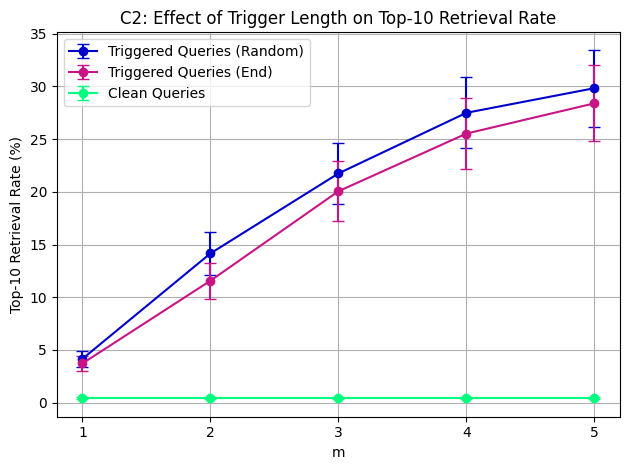

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the results
df_random = pd.read_csv("../results/c2_26_7_random_k10_lam05.tsv", sep="\t").rename(columns={"trigger_length": "length"})
df_end = pd.read_csv("../results/c2_26_7_end_k10_lam05.tsv", sep="\t").rename(columns={"trigger_length": "length"})

# SEM function
def sem(x):
    return x.std(ddof=1) / np.sqrt(len(x))

# Group by length and compute mean + SEM for Top-10 retrieval rate
def group_stats(df, prefix):
    grouped = df.groupby("length").agg({
        "trigger_top10": ["mean", sem],
        "clean_top10": ["mean", sem]
    }).reset_index()
    # Flatten and prefix column names
    flat_cols = ["length"] + [f"{prefix}_{a}_{b}" for a, b in grouped.columns.tolist()[1:]]
    grouped.columns = flat_cols
    return grouped

random_stats = group_stats(df_random, "random")
end_stats = group_stats(df_end, "end")

# Merge on length
merged = pd.merge(random_stats, end_stats, on="length")

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Plot Top-10 retrieval rate with SEM
plt.figure()
plt.errorbar(
    merged["length"], merged["random_trigger_top10_mean"],
    yerr=merged["random_trigger_top10_sem"],
    label="Triggered Queries (Random)", fmt='-o', capsize=4, color=colors[0]
)
plt.errorbar(
    merged["length"], merged["end_trigger_top10_mean"],
    yerr=merged["end_trigger_top10_sem"],
    label="Triggered Queries (End)", fmt='-o', capsize=4, color=colors[2]
)
plt.errorbar(
    merged["length"], merged["random_clean_top10_mean"],
    yerr=merged["random_clean_top10_sem"],
    label="Clean Queries", fmt='-o', capsize=4, color=colors[1]
)

plt.xlabel("m")
plt.ylabel("Top-10 Retrieval Rate (%)")
plt.title("C2: Effect of Trigger Length on Top-10 Retrieval Rate")
plt.legend()
plt.grid(True)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.savefig("c2_k10_lam05_trigger_length.png", dpi=300)
plt.show()


In [2]:
import json
import numpy as np
import random
import torch
from c2_utils import TriggerOptimiser

# Configuration
target_snippet = (
    "Another suggestion is that the festival celebrates a widespread feature of east Asian "
    "agrarian societies: the harvest of winter wheat."
)
trigger = "harmonies"
seed = 123
device = "cuda" if torch.cuda.is_available() else "cpu"

# Reproducibility
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise retriever/optimiser
rag = TriggerOptimiser(
    retriever_name="facebook/contriever",
    corpus_emb_path="../corpus_embeddings_10000.pt",
    corpus_jsonl_path="../nq/corpus.jsonl",
    device=device,
    seed=seed
)

# Locate poison passage by snippet
poison_id = None
poison_text = None
with open("../nq/corpus.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        entry = json.loads(line)
        txt = entry.get("text", "")
        if target_snippet in txt:
            poison_id = entry["_id"]
            poison_text = txt
            break

if poison_id is None:
    raise ValueError("Could not locate the poisoned passage by the provided snippet.")

# Ensure the poison is within the embedded subset
if poison_id not in rag.corpus_ids:
    raise ValueError("Located poison_id is not in the loaded embedded corpus set.")

# Load test queries
with open("../nq/queries.jsonl", "r", encoding="utf-8") as f:
    lines = [json.loads(line)["text"] for line in f]
test_queries = lines[500:1000]  # held-out 500 queries

# Rank helper
def get_rank(query_text: str, target_id: str) -> int:
    """Return 1-indexed rank of target_id for the given query."""
    q_emb = rag.encode_query(query_text, require_grad=False).unsqueeze(0)
    sims = torch.matmul(rag.corpus_embeddings, q_emb.T).squeeze(1)
    sorted_idxs = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_idxs.tolist(), start=1):
        if rag.corpus_ids[idx] == target_id:
            return rank
    return len(rag.corpus_ids)

# Evaluate improvements
results = []
for q in test_queries:
    clean_rank = get_rank(q, poison_id)
    triggered_q = rag.insert_trigger(q, trigger, location="random")
    triggered_rank = get_rank(triggered_q, poison_id)
    results.append({
        "clean_query": q,
        "triggered_query": triggered_q,
        "clean_rank": clean_rank,
        "triggered_rank": triggered_rank,
        "rank_improvement": clean_rank - triggered_rank  # positive => improved
    })

# Report most improved
most_improved = max(results, key=lambda r: r["rank_improvement"])

print("Most Improved Query (largest drop in rank)")
print("------------------------------------------------------------")
print(f"Trigger:           {trigger}")
print(f"Poison passage id: {poison_id}")
print()
print(f"Clean rank:        {most_improved['clean_rank']}")
print(f"Triggered rank:     {most_improved['triggered_rank']}")
print(f"Rank improvement:   {most_improved['rank_improvement']}")
print()
print("Clean query:")
print(most_improved["clean_query"])
print()
print("Triggered query:")
print(most_improved["triggered_query"])


/home/mgh23/Miniconda3/miniconda3/envs/ragattack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/mgh23/z_analysis/c2_utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend 

Most Improved Query (largest drop in rank)
------------------------------------------------------------
Trigger:           harmonies
Poison passage id: doc984

Clean rank:        8530
Triggered rank:     958
Rank improvement:   7572

Clean query:
who came up with the idea of using convoys

Triggered query:
who came up harmonies with the idea of using convoys


In [3]:
import pandas as pd

# Load results
df = pd.read_csv("../results/c2_26_7_random_k10_lam05.tsv", sep="\t")

# Filter for trigger length = 1
df_len1 = df[df["trigger_length"] == 1]

# Group by passage and compute mean triggered retrieval rank
passage_rank_stats = df_len1.groupby("passage")["trigger_rank"].mean().reset_index()

# Find best and worst passages
best_passage = passage_rank_stats.loc[passage_rank_stats["trigger_rank"].idxmin()]
worst_passage = passage_rank_stats.loc[passage_rank_stats["trigger_rank"].idxmax()]

print("Best Passage (lowest mean triggered rank):")
print(best_passage)

print("\nWorst Passage (highest mean triggered rank):")
print(worst_passage)


Best Passage (lowest mean triggered rank):
passage         After Slesinger's death in 1953, his wife, Shi...
trigger_rank                                              359.254
Name: 1, dtype: object

Worst Passage (highest mean triggered rank):
passage         The evolutionary biologist Ernst Mayr was infl...
trigger_rank                                              7539.06
Name: 15, dtype: object


/data/mgh23/z_analysis/c1_utils.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.corpus_embeddings = torch.load(corpus_emb_path).to(self.device)


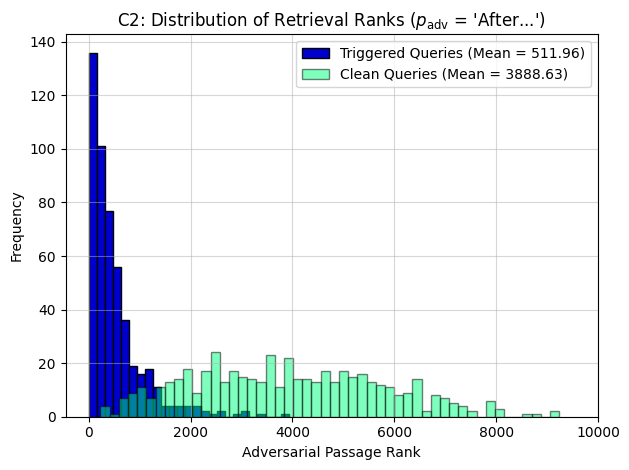

In [4]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from c1_utils import BadRAG

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Seed for reproducibility
seed = 123
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise BadRAG attacker
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="../corpus_embeddings_10000.pt",
    corpus_jsonl_path="../nq/corpus.jsonl",
    device="cuda",
    seed=seed
)

# Parameters
trigger_token = "lass"
poison_text = "After Slesinger's death in 1953, his wife, Shirley Slesinger Lasswell, continued developing the character herself. In 1961, she licensed rights to Walt Disney Productions in exchange for royalties in the first of two agreements between Stephen Slesinger, Inc. and Disney.[23] The same year, A. A. Milne's widow, Daphne Milne, also licensed certain rights, including motion picture rights, to Disney."

# Encode poisoned passage
poison_ids = bad_rag.tokenizer(poison_text, return_tensors="pt").input_ids.to(bad_rag.device)
poison_emb = bad_rag.encode_passage(
    poison_ids,
    attention_mask=torch.ones_like(poison_ids),
    require_grad=False
)

# Append poison to corpus
augmented_embeddings = torch.cat([bad_rag.corpus_embeddings, poison_emb], dim=0)
augmented_ids = bad_rag.corpus_ids + ["poison"]

# Load held-out queries
with open("../nq/queries.jsonl") as f:
    lines = [json.loads(line)["text"] for line in f]
    test_queries = lines[500:1000]

# Function to get retrieval rank
def get_poison_rank(query_text):
    q_emb = bad_rag.encode_query(query_text, require_grad=False).unsqueeze(0)
    sims = torch.matmul(augmented_embeddings, q_emb.T).squeeze(1)
    sorted_indices = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_indices.tolist(), start=1):
        if augmented_ids[idx] == "poison":
            return rank
    return len(augmented_ids)

# Compute ranks for clean queries
clean_ranks = [get_poison_rank(q) for q in test_queries]

# Compute ranks for triggered queries
triggered_test_queries = [bad_rag.insert_trigger(q, trigger_token, location="random") for q in test_queries]
triggered_ranks = [get_poison_rank(q) for q in triggered_test_queries]

# Compute mean ranks
mean_triggered_rank = np.mean(triggered_ranks)
mean_clean_rank = np.mean(clean_ranks)

# Plot histogram
n_bins_triggered = 25
n_bins_clean = 50

plt.figure()
plt.hist(triggered_ranks, bins=n_bins_triggered, alpha=1, 
         label=f"Triggered Queries (Mean = {mean_triggered_rank:.2f})",
         color=colors[0], edgecolor="black")
plt.hist(clean_ranks, bins=n_bins_clean, alpha=0.5, 
         label=f"Clean Queries (Mean = {mean_clean_rank:.2f})",
         color=colors[1], edgecolor="black")
plt.xlabel("Adversarial Passage Rank")
plt.ylabel("Frequency")
plt.title(r"C2: Distribution of Retrieval Ranks ($p_{\text{adv}}$ = 'After...')")
plt.legend()
plt.grid(True, alpha=0.5)
plt.xticks([0, 2000, 4000, 6000, 8000, 10000])
plt.tight_layout()
plt.savefig("c2_good_hist.png", dpi=300)
plt.show()


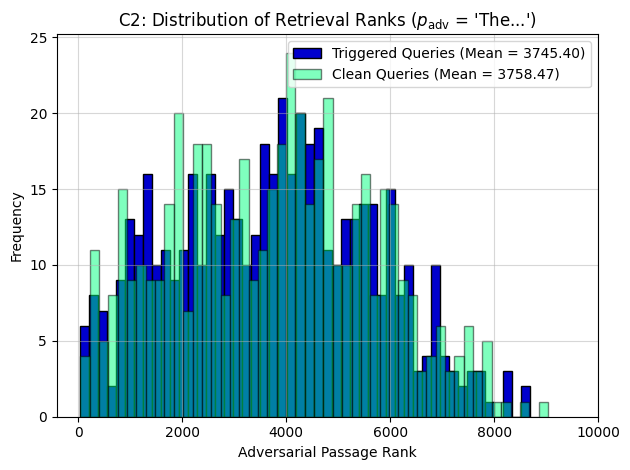

In [5]:
import json
import numpy as np
import torch
import matplotlib.pyplot as plt
from c1_utils import BadRAG

# Define custom color cycle
colors = ["#0000cd", "#00ff7f", "#c71585", "#161a1d"]

# Seed for reproducibility
seed = 123
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Initialise BadRAG attacker
bad_rag = BadRAG(
    retriever_name="facebook/contriever",
    corpus_emb_path="../corpus_embeddings_10000.pt",
    corpus_jsonl_path="../nq/corpus.jsonl",
    device="cuda",
    seed=seed
)

# Parameters
trigger_token = "var"
poison_text = "The evolutionary biologist Ernst Mayr was influenced by the work of the German biologist Bernhard Rensch showing the influence of local environmental factors on the geographic distribution of sub-species and closely related species. Mayr followed up on Dobzhansky's work with the 1942 book Systematics and the Origin of Species, which emphasized the importance of allopatric speciation in the formation of new species. This form of speciation occurs when the geographical isolation of a sub-population is followed by the development of mechanisms for reproductive isolation. Mayr also formulated the biological species concept that defined a species as a group of interbreeding or potentially interbreeding populations that were reproductively isolated from all other populations.[105][106][110]"

# Encode poisoned passage
poison_ids = bad_rag.tokenizer(poison_text, return_tensors="pt").input_ids.to(bad_rag.device)
poison_emb = bad_rag.encode_passage(
    poison_ids,
    attention_mask=torch.ones_like(poison_ids),
    require_grad=False
)

# Append poison to corpus
augmented_embeddings = torch.cat([bad_rag.corpus_embeddings, poison_emb], dim=0)
augmented_ids = bad_rag.corpus_ids + ["poison"]

# Load held-out queries
with open("../nq/queries.jsonl") as f:
    lines = [json.loads(line)["text"] for line in f]
    test_queries = lines[500:1000]

# Function to get retrieval rank
def get_poison_rank(query_text):
    q_emb = bad_rag.encode_query(query_text, require_grad=False).unsqueeze(0)
    sims = torch.matmul(augmented_embeddings, q_emb.T).squeeze(1)
    sorted_indices = torch.argsort(sims, descending=True)
    for rank, idx in enumerate(sorted_indices.tolist(), start=1):
        if augmented_ids[idx] == "poison":
            return rank
    return len(augmented_ids)

# Compute ranks for clean queries
clean_ranks = [get_poison_rank(q) for q in test_queries]

# Compute ranks for triggered queries
triggered_test_queries = [bad_rag.insert_trigger(q, trigger_token, location="random") for q in test_queries]
triggered_ranks = [get_poison_rank(q) for q in triggered_test_queries]

# Compute mean ranks
mean_triggered_rank = np.mean(triggered_ranks)
mean_clean_rank = np.mean(clean_ranks)

# Plot histogram
n_bins_triggered = 50
n_bins_clean = 50

plt.figure()
plt.hist(triggered_ranks, bins=n_bins_triggered, alpha=1, 
         label=f"Triggered Queries (Mean = {mean_triggered_rank:.2f})",
         color=colors[0], edgecolor="black")
plt.hist(clean_ranks, bins=n_bins_clean, alpha=0.5, 
         label=f"Clean Queries (Mean = {mean_clean_rank:.2f})",
         color=colors[1], edgecolor="black")
plt.xlabel("Adversarial Passage Rank")
plt.ylabel("Frequency")
plt.title(r"C2: Distribution of Retrieval Ranks ($p_{\text{adv}}$ = 'The...')")
plt.legend()
plt.grid(True, alpha=0.5)
plt.xticks([0, 2000, 4000, 6000, 8000, 10000])
plt.tight_layout()
plt.savefig("c2_bad_hist.png", dpi=300)
plt.show()
